In [2]:
import os
import sys

PROJECT_HOME = os.environ["TSHPO_HOME"]
sys.path.append(PROJECT_HOME)
sys.path.append(f"{PROJECT_HOME}/deps")
from tshpo.lib_class import AnaHelper
import pandas as pd
from scipy.stats import stats
from tshpo.lib_class import FileHelper

EPOCH_KEY = "metric_400"
files = [
    "c04_tshpo_acc_compare_v11_original_20241101_1810.csv.gz",
    "c04_tshpo_acc_compare_v12_middle_original_20241103_0821.csv.gz",
    "c04_tshpo_acc_compare_v12_big_original_20241102_1631.csv.gz",
]
t_df = []
for _f in files:
    t_df.append(AnaHelper.load_exp_from_csv_tshpo(_f, iterations=[200, 300, 400, 500]))
SELECT_TOP_N = 3
process_df = pd.concat(t_df)
process_df = AnaHelper.append_data_size_type(process_df)
process_df = AnaHelper.append_normal_hpo_name(process_df)

outputs = []
for _n_high_perf_model in [2, 3, 4]:
    _df = process_df[
        (process_df['n_high_performing_model'].isin([_n_high_perf_model, 14])) & (process_df['metric'] != "f1")]
    _cdf = pd.pivot_table(_df, index=['metric', 'hpo_opt_method', 'data_size_type', 'dataset', 'fold_index'],
                          columns=['n_high_performing_model'],
                          values=[EPOCH_KEY]).reset_index()
    _cdf.columns = ['metric', 'hpo_opt_method', 'data_size_type', 'dataset', 'fold_index', "tshpo", "baseline"]
    _cdf['improve'] = _cdf['tshpo'] - _cdf['baseline']
    _cdf['n_top'] = _n_high_perf_model
    _cdf = _cdf.round(4)

    outputs.append(_cdf)
mdf = pd.concat(outputs, axis=0)
mdf

Parse configs
Parse configs
Parse configs


,metric,hpo_opt_method,data_size_type,dataset,fold_index,tshpo,baseline,improve,n_top
0,accuracy,BO,large,PhishingWebsites,0,0.9711,0.9575,0.0136,2
1,accuracy,BO,large,PhishingWebsites,1,0.9774,0.9602,0.0172,2
2,accuracy,BO,large,PhishingWebsites,2,0.9774,0.9638,0.0136,2
3,accuracy,BO,large,PhishingWebsites,3,0.9801,0.9611,0.0190,2
4,accuracy,BO,large,PhishingWebsites,4,0.9837,0.9593,0.0244,2
...,...,...,...,...,...,...,...,...,...
835,roc_auc,RS,small,tic-tac-toe,0,1.0000,1.0000,0.0000,4
836,roc_auc,RS,small,tic-tac-toe,1,1.0000,1.0000,0.0000,4
837,roc_auc,RS,small,tic-tac-toe,2,1.0000,1.0000,0.0000,4
838,roc_auc,RS,small,tic-tac-toe,3,1.0000,1.0000,0.0000,4


In [9]:

def _calc_p_value(se):
    _fdf = mdf[
        (mdf["n_top"] == se['n_top'][0]) &
        (mdf["metric"] == se['metric'][0]) &
        (mdf["hpo_opt_method"] == se['hpo_opt_method'][0]) &
        (mdf["data_size_type"] == se['data_size_type'][0])
        ]
    df_cleaned = _fdf.dropna()
    _baseline = df_cleaned['baseline']
    _tshpo = df_cleaned['tshpo']

    if se['metric'][0] == "roc_auc" and se['hpo_opt_method'][0] == "HB" and se['data_size_type'][0] == "large":
        i = 1

    t, p = stats.ttest_rel(_baseline.values, _tshpo.values)
    se["p_value"] = round(p, 3)
    se['n_samples'] = _baseline.shape[0]
    return se


In [4]:
# ID20241127162742452351
_cdf = pd.pivot_table(mdf, index=['n_top', 'metric', 'hpo_opt_method', 'data_size_type'],
                      values=["tshpo", 'baseline'], aggfunc=["mean", "std"]).reset_index()

_cdf["tshpo_v"] = _cdf.apply(lambda x: f"{x[('mean', 'tshpo')]:.3f}(±{x[('std', 'tshpo')]:.3f})", axis=1)
_cdf["baseline_v"] = _cdf.apply(lambda x: f"{x[('mean', 'baseline')]:.3f}(±{x[('std', 'baseline')]:.3f})", axis=1)
final_df = _cdf.loc[:, ['metric', "n_top", 'hpo_opt_method', 'data_size_type', 'tshpo_v', 'baseline_v']]
final_df = final_df.sort_values(by=['metric', 'n_top'])
final_df = final_df.apply(_calc_p_value, axis=1)
# final_df = AnaHelper.append_normal_model_name(final_df.reset_index())
# final_df = final_df[final_df['hpo_opt_method'] == "RS"]
final_df = final_df.drop("n_samples", axis=1)
final_df = AnaHelper.append_normal_metric_name(final_df)
FileHelper().to_latex(final_df, "acc_improve.tex", index=False)
final_df

Saved to /Users/sunwu/SW-Research/AutoML-Benchmark/tshpo/runtime/exp_outputs/acc_improve.tex


,metric,n_top,hpo_opt_method,data_size_type,tshpo_v,baseline_v,p_value
,,,,,,,
0,Accuracy,2,BO,large,0.919(±0.056),0.909(±0.052),0.000
1,Accuracy,2,BO,middle,0.939(±0.050),0.926(±0.048),0.000
2,Accuracy,2,BO,small,0.891(±0.099),0.870(±0.108),0.000
3,Accuracy,2,HB,large,0.915(±0.056),0.897(±0.061),0.001
4,Accuracy,2,HB,middle,0.937(±0.052),0.917(±0.054),0.000
5,Accuracy,2,HB,small,0.882(±0.104),0.870(±0.105),0.000
6,Accuracy,2,RS,large,0.915(±0.056),0.911(±0.053),0.002
7,Accuracy,2,RS,middle,0.937(±0.051),0.926(±0.052),0.000
8,Accuracy,2,RS,small,0.888(±0.095),0.870(±0.104),0.000


In [11]:
# 精度提升
mdf.groupby(by=['hpo_opt_method'])['improve'].mean().round(2)

hpo_opt_method
BO    0.01
HB    0.02
RS    0.01
Name: improve, dtype: float64

In [6]:
plot_df = pd.melt(mdf, id_vars=['metric', 'hpo_opt_method', 'data_size_type', "n_top"],
                  value_vars=['tshpo', 'baseline'])
plot_df["data_size_type"].drop_duplicates()
plot_df

,metric,hpo_opt_method,data_size_type,n_top,variable,value
0,accuracy,BO,large,2,tshpo,0.9711
1,accuracy,BO,large,2,tshpo,0.9774
2,accuracy,BO,large,2,tshpo,0.9774
3,accuracy,BO,large,2,tshpo,0.9801
4,accuracy,BO,large,2,tshpo,0.9837
...,...,...,...,...,...,...
5035,roc_auc,RS,small,4,baseline,1.0000
5036,roc_auc,RS,small,4,baseline,1.0000
5037,roc_auc,RS,small,4,baseline,1.0000
5038,roc_auc,RS,small,4,baseline,1.0000


Saved to /Users/sunwu/SW-Research/AutoML-Benchmark/tshpo/runtime/exp_outputs/hpo_improve_2.pdf
Saved to /Users/sunwu/SW-Research/AutoML-Benchmark/tshpo/runtime/exp_outputs/hpo_improve_3.pdf
Saved to /Users/sunwu/SW-Research/AutoML-Benchmark/tshpo/runtime/exp_outputs/hpo_improve_4.pdf


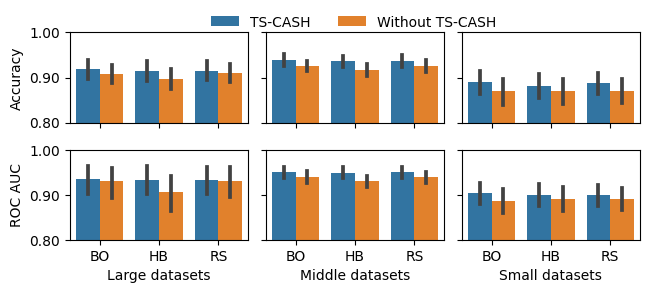

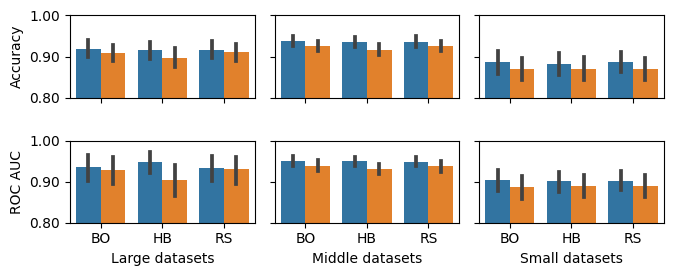

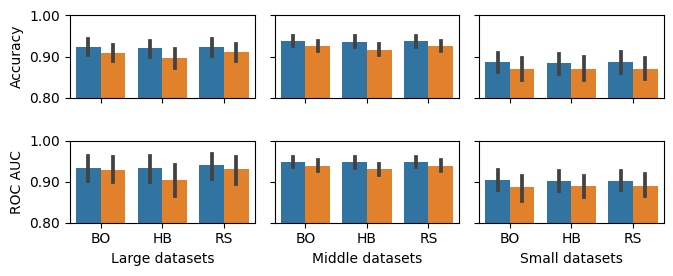

In [12]:
# ID2024112716241835056755
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns

for _top_n in [2, 3, 4]:
    _plot_df = plot_df[plot_df['n_top'] == _top_n]
    g = sns.FacetGrid(_plot_df, col="data_size_type", row='metric', height=1.5, aspect=1.5, despine=False, sharey=True)
    g.map_dataframe(sns.barplot, x="hpo_opt_method", y="value", hue="variable", palette=sns.color_palette())
    ax = None
    for (_metric, _data_size_type), ax in g.axes_dict.items():
        ax = ax
        ax.set_title(None)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        ax.set_ylim(0.8, 1)
        if _metric.lower() == "accuracy":
            ax.set_ylabel("Accuracy")
        elif _metric.lower() == "roc_auc":
            ax.set_ylabel("ROC AUC")
        ax.grid(False)
        if _data_size_type.lower() == "small":
            ax.set_xlabel("Small datasets")
        elif _data_size_type.lower() == "large":
            ax.set_xlabel("Large datasets")
        else:
            ax.set_xlabel("Middle datasets")
    if _top_n == 2:
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        h, l = ax.get_legend_handles_labels()
        l = ["TS-CASH" if _l == "tshpo" else "Without TS-CASH" for _l in l]
        g.add_legend(handles=h, labels=l, bbox_to_anchor=(0.55, 0.92), ncol=2)
    FileHelper().to_pdf(g, f"hpo_improve_{_top_n}.pdf")

In [ ]:
## 找出 TSHPO 的效果
res = mdf.query("hpo_opt_method=='BO' and n_top==4")
res

,metric,hpo_opt_method,data_size_type,dataset,fold_index,tshpo,baseline,improve,n_top
0,accuracy,BO,large,PhishingWebsites,0,0.9702,0.9575,0.0127,4
1,accuracy,BO,large,PhishingWebsites,1,0.9756,0.9602,0.0154,4
2,accuracy,BO,large,PhishingWebsites,2,0.9810,0.9638,0.0172,4
3,accuracy,BO,large,PhishingWebsites,3,0.9783,0.9611,0.0172,4
4,accuracy,BO,large,PhishingWebsites,4,0.9837,0.9593,0.0244,4
...,...,...,...,...,...,...,...,...,...
555,roc_auc,BO,small,tic-tac-toe,0,1.0000,1.0000,0.0000,4
556,roc_auc,BO,small,tic-tac-toe,1,1.0000,1.0000,0.0000,4
557,roc_auc,BO,small,tic-tac-toe,2,1.0000,1.0000,0.0000,4
558,roc_auc,BO,small,tic-tac-toe,3,1.0000,1.0000,0.0000,4


In [23]:
tshpo = res.groupby(by=['dataset', 'metric'])['tshpo'].agg(['mean', 'std'])
tshpo.reset_index()
tshpo.to_csv("tshpo_res.csv")

